# Project 2: Sequence Alignment and Phylogeny


   <div class="alert alert-block alert-danger">
    <center>Due: <b>Monday, 26 September, 8:59pm</b>.</center> 
   </div>
   
   <div class="alert alert-block alert-warning">
   <center>
       <b>Collaboration and Resource Policy</b>
    </center>
    For this assignment, you are encouraged to work with one other person. Your team must satisfy these constraints:
    
   1. You **did not work together on Project 1**.
   2. You and your partner have a **total number of siblings that is divisible by two** (e.g., if you have one sibling, you need to find a partner with 1, 3, 5, or 7 siblings. If anyone has more than 7 siblings, they can partner with anyone!)
    
We expect most students will have the best learning experience on this assignment by working with a partner, but if you prefer to work alone it is permissible to do this assignment on your own.
    
You are encouraged to discuss these problems with anyone you want, including other students in the class. If you do discuss the specific questions in the assignment with anyone other than your assignment partner and the course staff, though, you should list them in the _External resources used_ section below.
    
You are welcome to use any resources you want for this assignment, other than ones that would defeat the purpose of the assignment. This means you should not look at answers or code from any other students in the class (other than your collaboration with your partner) or from previous offerings of this course, and if you find code that implements the problem you are being asked to do for the assignment, you should not use that code. 

You should document all external resource you use that are not part of the course materials in the _External resources used_ section below.
    </div>

**Team submitting this assignment:**  
<div class="alert alert-success">
    <b><em>list each member of your team here, including both your name and UVA computing id</em></b>
    Alison Lu (atl9rn), Joey Elsisi (jre3wjh)
</div>

**External resources used:** 
<div class="alert alert-success">
<em>It is not necessary to list the course materials, but if you used any other resources, including discussing problems with students not on your team, list them here.</em>
</div>

 <div class="alert alert-block alert-warning">
    
<b>Submission</b>: Please submit the code you wrote to generate your answers for all parts using this form: https://forms.gle/gv144kv3KRo67uUX7. Your answers should be in the Jupyter Notebook, along with your code. Before submission, you should make a copy of your notebook file with the name uvaid1\_uvaid2.ipynb (where uvaidn is each teammates UVA id) so the submitted file identifies you. You and your partner should submit a single file once together. Submission is due 8:59 pm on Wednesday, 21 September.

## Getting Started

Install basic required packages, should be run only once. You may need to restart the jupyter python kernel (under the Kernel menu) after this. (You can execute this directly in the notebook but running the command below.)

In [7]:
% pip install -r requirements.txt

UsageError: Line magic function `%` not found.


In [8]:
import numpy as np
import blosum as bl
import networkx as nx
import matplotlib.pyplot as plt
import utils
from itertools import chain

## Part 1: Global Sequence Alignment

Below we provide the sequence alignment code from [Class 6](https://computingbiology.github.io/class6/). You are welcome to use and modify this code however you want in your solution, but should answer the questions below based on this provided code.

In [9]:
def simpleMatch(a, b):
    return 1 if a == b else -1


def distanceMatch(a, b):
    return 0 if a == b else -1


def linearGap(n):
    return -1 * n


def alignmentScore(s1, s2, gapPenalty, match):
    if not s1 or not s2:
        return gapPenalty(len(s1)) + gapPenalty(len(s2))
    else:
        return max(gapPenalty(1) + alignmentScore(s1, s2[1:], gapPenalty, match),
                   gapPenalty(1) + alignmentScore(s1[1:], s2, gapPenalty, match),
                   match(s1[0], s2[0]) + alignmentScore(s1[1:], s2[1:], gapPenalty, match))

In [10]:
def alignmentScoreDP(s1, s2, gapPenalty, match):
    m = np.zeros((len(s1) + 1, len(s2) + 1))
    m[0, 0] = 0
    for i in range(1, len(s1) + 1):
        m[i, 0] = gapPenalty(i)
    for j in range(1, len(s2) + 1):
        m[0, j] = gapPenalty(j)
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            m[i, j] = max(gapPenalty(1) + m[i, j - 1],
                          gapPenalty(1) + m[i - 1, j],
                          match(s1[i - 1], s2[j - 1]) + m[i - 1, j - 1])
    return m


def readAlignment(s1, s2, m, gapPenalty, match):
    i = len(s1)
    j = len(s2)
    s1a = ""
    s2a = ""
    score = 0
    while i > 0 or j > 0:
        if i > 0 and j > 0 and m[i, j] == m[i - 1, j - 1] + match(s1[i - 1], s2[j - 1]):
            i = i - 1
            j = j - 1
            score += match(s1[i], s2[j])
            s1a = s1[i] + s1a
            if s1[i] == s2[j]:
                s2a = s2[j] + s2a
            else:
                s2a = s2[j].lower() + s2a
        elif i > 0 and m[i, j] == m[i - 1, j] + gapPenalty(1):
            i = i - 1
            score += gapPenalty(1)
            s1a = s1[i] + s1a
            s2a = '-' + s2a
        elif j > 0 and m[i, j] == m[i, j - 1] + gapPenalty(1):
            j = j - 1
            score += gapPenalty(1)
            s1a = '-' + s1a
            s2a = s2[j] + s2a
        else:
            assert False
    return (s1a, s2a, score)


def showAlignment(s1, s2, gapPenalty, match):
    m = alignmentScoreDP(s1, s2, gapPenalty, match)
    r = readAlignment(s1, s2, m, gapPenalty, match)
    print(r[0] + "\n" + r[1] + "\n" + str(r[2]))
    return (m, r)

In [11]:
# Example
r = showAlignment("GATT", "GCAT", linearGap, simpleMatch)

G-ATT
GCA-T
1


Here's the version that supports affine gap penalties (from Class 6):

In [5]:
def alignmentScoreDPG(s1, s2, gapPenalty, match):
    m = np.zeros((len(s1) + 1, len(s2) + 1))
    m[0, 0] = 0
    for i in range(1, len(s1) + 1):
        m[i, 0] = gapPenalty(i)
    for j in range(1, len(s2) + 1):
        m[0, j] = gapPenalty(j)
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            m[i, j] = max(chain((gapPenalty(g) + m[i, j - g] for g in range(1, j)),
                                (gapPenalty(g) + m[i - g, j] for g in range(1, i)),
                                [(match(s1[i - 1], s2[j - 1]) + m[i - 1, j - 1])]))
    return m


def readAlignmentG(s1, s2, m, gapPenalty, match):
    i = len(s1)
    j = len(s2)
    s1a = ""
    s2a = ""
    score = 0
    while i > 0 or j > 0:
        if i > 0 and j > 0 and m[i, j] == m[i - 1, j - 1] + match(s1[i - 1], s2[j - 1]):
            i = i - 1
            j = j - 1
            s1a = s1[i] + s1a
            s2a = (s2[j] if s1[i] == s2[j] else s2[j].lower()) + s2a
            score += match(s1[i], s2[j])
        else:
            foundit = False
            for g in range(1, i + 1):
                if m[i, j] == m[i - g, j] + gapPenalty(g):
                    s1a = s1[i - g:i] + s1a
                    s2a = ('-' * g) + s2a
                    i = i - g
                    score += gapPenalty(g)
                    foundit = True
                    break
            if not foundit:
                for g in range(1, j + 1):
                    if m[i, j] == m[i, j - g] + gapPenalty(g):
                        s1a = ('-' * g) + s1a
                        s2a = s2[j - g:j] + s2a
                        j = j - g
                        score += gapPenalty(g)
                        foundit = True
                        break
            assert foundit
    return (s1a, s2a, score)


def showAlignmentG(s1, s2, gapPenalty, match):
    m = alignmentScoreDPG(s1, s2, gapPenalty, match)
    r = readAlignmentG(s1, s2, m, gapPenalty, match)
    print(r[0] + "\n" + r[1] + "\n" + str(r[2]))
    return (m, r)

In [13]:
def affineGap(n, gp=-1, gn=-0.2):
    return gp + (n - 1) * gn

In [14]:
# Example
s1 = "AAAGAATTCA"
s2 = "AAATCA"
r = showAlignmentG(s1, s2, affineGap, simpleMatch)

AAAGAATTCA
AAA----TCA
4.4


<div class="alert alert-success">

**Problem 1 (a).** Run the given algorithm to find a global sequence alignment for the OCA2 genes (a key gene for the production of melanin) for humans and mice with the following gap penalties (still using simpleMatch as the match score function):

  a. `linearGap` penalty
    
  b. `affineGap` penalty, with $gp=-0.2$

  c. `affineGap` penalty, with $gp=-0.1$
    
</div>


In [15]:
human_oca2, mouse_oca2 = utils.load_oca2_sequences()

In [16]:
# Your code here
m, r = showAlignment(human_oca2, mouse_oca2, linearGap, simpleMatch)


def affineGap(n, gp=-0.2, gn=-0.2):
    return gp + (n - 1) * gn


m1, r1 = showAlignmentG(human_oca2, mouse_oca2, affineGap, simpleMatch)


def affineGap(n, gp=-0.1, gn=-0.2):
    return gp + (n - 1) * gn


m2, r2 = showAlignmentG(human_oca2, mouse_oca2, affineGap, simpleMatch)

-GTTCT--TACTTCGAAG-GCTGTGCTCCG----CTCACCATCCAGAGCGGAGGTGCGGACC-T-TA-AACTCA-CTCC--TGGA----GA-A--AGATCTGCAAGTGC-GCAGAGAGAAGACTGGCAGTGGAGCATGCATCTGGAGGGCAGAGACGGC-A-GGCGGTACCCCGGCGCGCCGGCG-GTGGAGCTCCTGCAGACGTCCGTGCC-CAGCGGACTCGCT-GAACTTGTGGC--CGGCA-AGC
CccTCTGGggCTgC-AAGTGC-cTGCTgaGAAATCTtA-CA-CC--AG-GGttGTGC--tCCATCcACgACTCAGagCCTTTGGATCTGGACACTAGA-CTtC-AcTGCTG--GAGAG-AGA-T--CAG-cGAG--T-CATC---A-GaCAGA-tCaGCAACGG-GG-A--CatGCGC-CtaGaGAacaaAG-aCaT-CAG--G-CtG-GCCTCAGCcG--T-GCTGGAAgTaG-aGCTACacCAGA-C
25
---------G-T-----T-C-T--T---A---CTT-CGA--A-GG-CTGTGCTCC--GCTCAC--CATCCAGAG-C---GGAGGTGC-GGAC-CTTAA-AC-TCACT-CCTGGAGA-AAGATC-TGC-AAGTGC--GCAGA-GAGA--AG--ACTGGCAGTGGAGCAT--GCATCT-G-G-AGGGC-AGAGAC--GGCAGGC-GGTACCC-C-GGCGCG-CCGGCGGTGG-AGCTCCTGCAGACGTCCGTGCCCAGCGGACTCGCTGAACTTGTGGCCGGCAAGC
CCCTCTGGGGCTGCAAGTGCCTGCTGAGAAATCTTAC-ACCAGGGT-TGTGCTCCAT-C-CACGAC-T-CAGAGCCTTTGGA--T-CTGGACACT--AGACTTCACTG-CTGGAGAG-AGATCA-GCG-AGT-CAT-CAGAC-AGATCAGCAAC-G---G-GGA-CATGCGC--CTAGAGAA---CAA-AGACAT--CAGGCTGG---CCT

In [17]:
# print(m, r)

<div class="alert alert-success">

**Problem 1 (b).** Use the given function to convert these sequences to their amino-acid sequences, and then re-run alignment for all sequences with the default parameters for `affineGap`.
</div>


In [18]:
# Convert sequence of nucleotides to amino acids using codon table lookup
# Example
utils.convert_to_amino("AAATGCGGCGTA")

'KCGV'

In [19]:
# Your code here
seq1 = utils.convert_to_amino(human_oca2)
# print(seq1)
seq2 = utils.convert_to_amino(mouse_oca2)


# print(seq2)

def affineGap(n, gp=-1, gn=-0.2):
    return gp + (n - 1) * gn


ma, ra = showAlignmentG(seq1, seq2, affineGap, simpleMatch)

VLTSKAVLRS-----------PSRAEVRTLNSL----L-----E------KDLQVR----RE----------KTGSGACIWRAETAGGTPARRRWSSCRRPCPADSLNLWPAS
--pSgA--aSAC_EILHQGCAPS-----TtqSLWIWTLDFTAGERSASHQtD-QqRGHAPREQRHQAGLSRA--GS-----RA-----TP--------------D--------
-13.799999999999999


## Part 2: Alignment with Amino-Acids


The PAM<em>n</em> matrix (to be covered in [Class 6](https://computingbiology.github.io/class6/)) represents the likelihood of the occurrence of each tranformation during a time period where there are _n_ total mutation events per 100 amino acids.

<div class="alert alert-success">

**Problem 2 (a)** What would a negative value of an entry in a PAM 1 matrix $M$ indicate? Explain in terms of evolution and functionality of the proteins. Note that $M_{ij} = log(\frac{q_{ij}}{p_ip_j})$ where $q_{ij}$ indicates the frequency of amino acids $i$ and $j$ observed to align in related sequences, and $p_i$ and $p_j$ represent the frequencies of occurrence of $i$ and $j$.
</div>

A negative entry in a PAM 1 matrix indicates that q_{i,j} / p_i * p_j is less than 1 (but greater than 0), which means that p_i * p_j is greater than q_{i,j}. This means that the alignment frequency is very low while the independent frequences of i and j are relatively higher. For this to mathematically work, the alignment frequency must be less than 1. This likely means that they are inversely correlated or actively harmful for each other. It likely means that when amino acid i gets replaced by amino acid j or vice versa, the organism no longer becomes viable and thus cannot spread its genes through evolution.

<div class="alert alert-success">
    
**Problem 2 (b).** The BLOSUM<em>x</em> matices are created by clustering sequences with more than <em>x</em>% similarity into one single sequence and comparing sequences with more than <em>x</em>% divergence. Therefore, BLOSUM matrices are based on local alignments. Which of BLOSUM 50 and 60 contain more evoluationary divergence? 
    
</div>

The percentage is a ceiling for pairwise identity. This means that BLOSUM 50 should be used for sequences with more evolutionary divergence. If X is too high there will be little sequences grouped together.

<div class="alert alert-success">

**Problem 2 (c).** Use the BLOSUM62 matrix as your scoring function to perform global alignment on the amino-acid sequences using `linearGap` (default parameters).
</div>

In [20]:
blosum_matrix = bl.BLOSUM(62)

In [21]:
# Your code here

def blossumMatch(a, b):
    key = str(a).upper() + str(b).upper()
    return blosum_matrix[key]


# print(seq1) # human
# print(seq2) # mouse

ma1, ra1 = showAlignmentG(seq1, seq2, linearGap, blossumMatch)



---VLTSKA---VL-R--SPSRAEVRTLNSL----LEKDLQVRREKTGSGACIWR-A--ET---AGGTPAR-RR-WS--SCRRPCPADSLNLWPAS
PSGa-aS-AC_EiLHqGCaPS---t-T-qSLWIWTL--Df------T-aGe---RSASHqTDQQrGhaP-REqRHqaGLS--R---AgS-ratP-d
68.0


_Type your answer here_

<div class="alert alert-success">

**Problem 2 (d).** How do your results for Problem 2c differ from the earlier ones of Problem 1a (with `linearGap`)? Which one would you say is more biologically plausible?
</div>

The linear gap score for 2c was 68.0 while the linear gap score for 1a was 25, so the score is higher for the amino acids. This makes sense because amino acids have multiple encodings so even if two nucleotides are different they could encode for the same amino acid and thus be a match.

<div class="alert alert-success">

**Problem 2 (e).** We discussed in class that the PAM matrices follow the Markov property and a mismatch at any site depends only on the amino acid at that site and the transition probability. Is this a suitable representation of evolution? Think about if replacements are equaly likely to occur over entire sequences. It may help to consider the difference between PAM and BLOSUM matrices.
</div>

Replacements are not equally likely to occur over entire sequences. Due to the shape of chromosomes replacements are more likely to happen in the cross section where the chromosome is more tightly wound. In addition, certain genomes may be more critical than others, so these areas may be less resistant to change and thus have a different associated score. BLOSUM accounts for this by being based on local alignments, and is considered to have better performance than the PAM matrices.

## Part 3: Local Sequence Alignment


<div class="alert alert-success">
    
<b>Problem 3 (a).</b> Implement local alignment (for both the normal and affine-gap penalties) using the Smith-Waterman algorithm. Feel free to re-use and modify the given Needleman–Wunsch algorithm. 
</div>

In [22]:
def highestScore(matrix, n, m):
    # n x m matrix
    maxScore = -99
    maxIndex = (0, 0)
    for i in range(n):
        for j in range(m):
            if matrix[i, j] > maxScore:
                maxScore = matrix[i, j]
                maxIndex = (i, j)
    return maxIndex


def readLocalAlignmentG(s1, s2, m, gapPenalty, match):
    maxIndex = highestScore(m, len(m), len(m[0]))
    i = maxIndex[0]  #len(s1)
    j = maxIndex[1]  #len(s2)
    s1a = ""
    s2a = ""
    score = 0
    while i > 0 or j > 0:
        #condition about zero, stop the program

        diagonal_score = m[i - 1, j - 1]
        horizontal_score = m[i, j - 1]
        vertical_score = m[i - 1, j]
        #if all three are zero, end algorithm
        if diagonal_score == 0 and horizontal_score == 0 and vertical_score == 0:
            if i > 0 and j > 0 and m[i, j] == m[i - 1, j - 1] + match(s1[i - 1], s2[j - 1]):
                i = i - 1
                j = j - 1
                s1a = s1[i] + s1a
                s2a = (s2[j] if s1[i] == s2[j] else s2[j].lower()) + s2a  # todo, understand this line
                score += match(s1[i], s2[j])

            # i = i - 1
            # j = j - 1
            # s1a = s1[i] + s1a # in come cases, these next three lines are needed to make the algorithm work, in others no
            # s2a = s2[j] + s2a
            # score += match(s1[i], s2[j])
            break
        if i > 0 and j > 0 and m[i, j] == m[i - 1, j - 1] + match(s1[i - 1], s2[j - 1]):
            i = i - 1
            j = j - 1
            s1a = s1[i] + s1a
            s2a = (s2[j] if s1[i] == s2[j] else s2[j].lower()) + s2a  # todo, understand this line
            score += match(s1[i], s2[j])
        else:
            foundit = False
            for g in range(1, i + 1):
                if m[i, j] == m[i - g, j] + gapPenalty(g):
                    s1a = s1[i - g:i] + s1a
                    s2a = ('-' * g) + s2a
                    i = i - g
                    score += gapPenalty(g)
                    foundit = True
                    break
            if not foundit:
                for g in range(1, j + 1):
                    if m[i, j] == m[i, j - g] + gapPenalty(g):
                        s1a = ('-' * g) + s1a
                        s2a = s2[j - g:j] + s2a
                        j = j - g
                        score += gapPenalty(g)
                        foundit = True
                        break
            assert foundit
    return (s1a, s2a, score)


def localAlignmentScoreDPG(s1, s2, gapPenalty, match):
    m = np.zeros((len(s1) + 1, len(s2) + 1))
    m[0, 0] = 0
    for i in range(1, len(s1) + 1):
        for j in range(1, len(s2) + 1):
            m[i, j] = max(chain([0],
                                (gapPenalty(g) + m[i, j - g] for g in range(1, j)),
                                (gapPenalty(g) + m[i - g, j] for g in range(1, i)),
                                [(match(s1[i - 1], s2[j - 1]) + m[i - 1, j - 1])]))
    return m


def showAlignmentLocal(s1, s2, gapPenalty, match):
    # Although it is often useful to return all high scoring local alignments for an input pair, 
    # it is sufficient if your algorithm just returns the single highest-scoring local alignment 
    # (as shown in the examples below).
    #k = alignmentScoreDPG(s1, s2, gapPenalty, match) # for comparison
    #print(k)
    m = localAlignmentScoreDPG(s1, s2, gapPenalty, match)
    r = readLocalAlignmentG(s1, s2, m, gapPenalty, match)
    print(r[0] + "\n" + r[1] + "\n" + str(r[2]))
    return (m, r)

We've included some assert statements that can help you check the correctness of your algorithm. As with any algorithm, correctness on these test inputs does not guarantee algorithmic correcntess, but can be useful to debug.

In [23]:
# Example expected output
# Taken from https://en.wikipedia.org/wiki/Smith–Waterman_algorithm)
r = showAlignmentLocal("GGACTTAAATAGA", "TGTTGGTGATCCACGTGG", linearGap, simpleMatch)
#r = showAlignmentLocal("GGTTGA", "TGTTA", linearGap, simpleMatch)

GG
GG
2


In [24]:
# First assert
r = showAlignmentLocal("GGTTGACTA", "TGTTACGG", linearGap, simpleMatch)
assert (r[1][2] == 4 and "GTTGAC" in r[1] and "GTT-AC" in r[1])

# Second assert
r = showAlignmentLocal("GGACTTAAATAGA", "TGTTGGTGATCCACGTGG", linearGap, simpleMatch)
assert (r[1][2] == 2 and "GG" == r[1][0] and "GG" == r[1][1])

# Third assert
r = showAlignmentLocal("TTGA", "GGCC", linearGap, simpleMatch)
assert (r[1][2] == 1 and "G" == r[1][0] and "G" == r[1][1])

# Fourth assert
r = showAlignmentLocal("TACGGGCCCGCTAC", "TAGCCCTATCGGTCA", linearGap, simpleMatch)

assert (r[1][2] == 4 and "TA-CGG" in r[1] and "TATCGG" in r[1])

GTTGAC
GTT-AC
4
GG
GG
2
G
G
1
TA-CGG
TATCGG
4


<div class="alert alert-success">
    
<b>Problem 3 (b).</b> Align the provided hemoglobin genes for:
    <ol>
        <li>`polar bears` & `black bears`,</li>
        <li>`humans` & `chimps`,</li>
        <li>`polar bears` & `humans`, and</li>
        <li>`black bears` & `chimps`.</li>
    </ol>

Use `linearGap`.
    
Take note of the scores you get. What do you notice?
</div>

In [25]:
polar_bear, black_bear, human, chimp = utils.get_hemoglobin_sequences()
print(len(black_bear))

589


In [26]:
#polar_black_r = showAlignmentLocal(polar_bear, black_bear, linearGap, simpleMatch)
polar_black_m = localAlignmentScoreDPG(polar_bear, black_bear, linearGap, simpleMatch)
print(polar_black_m)

[[  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   1.   0.   0.]
 [  0.   0.   0. ...   1.   0.   0.]
 ...
 [  0.   0.   0. ... 323. 322. 321.]
 [  0.   0.   0. ... 322. 324. 323.]
 [  0.   1.   1. ... 321. 323. 325.]]


In [27]:
r = readLocalAlignmentG(polar_bear, black_bear, polar_black_m, linearGap, simpleMatch)  # 325
print(r[1][2])


A


In [ ]:
print(len(human))

In [ ]:
r = showAlignmentLocal(human, chimp, linearGap, simpleMatch)  # 801
r = showAlignmentLocal(polar_bear, human, linearGap, simpleMatch)  # 503
r = showAlignmentLocal(black_bear, chimp, linearGap, simpleMatch)  # 209


The alignment score with humans and chimps is a lot higher than that of humans with polar bears or chimps with black bears. As humans and chimps are close ancestors of each other, this makes sense.

<div class="alert alert-success">

<b>Problem 3 (c).</b> Use <a href="https://blast.ncbi.nlm.nih.gov/">BLAST</a> for the above pairs of sequences. Carefully inspect the returned results to see if they are similar to the alignments you obtained above.
</div>

We used megablast with a match, mismatch score of 1, -1, a gap opening cost of 0 and a gap extensions cost of 2 for all the below results:
                 BLAST, us
Human/Chimp score: 919, 801
black/polar score: 262, 325
polar/human score: 495, 503
black/chimp score: 189, 209

As expected, we see differences in the scores of our alignments verses those found by BLAST. This could be due to different parameter values like the gap extension penalty, differences in how the algorithm is implemented, etc. BLAST returns several local alignments, not just the maximum score alignment. We can compare the outputs of the maximal score of a BLAST query with our own using a diff checker. What jumps out immedietly in the comparison is that BLAST's alignment contains no gaps. This is impressive given the 0 cost for a gap opening. The length of the alignment is also significantly shorter, BLAST does a much better job of honing in on specific sequences then our algorithm.
- another difference is that our algorithm enters gaps into both sequences, not just the one we are comparing too

<div class="alert alert-success">

<b>Problem 3 (d).</b> Could you run an affine-gap-loss version of your local-alignment algorithm for the given sequences? How much time did BLAST take?
Can you think of any optimizations you could make to make the affine-gap-loss version run faster- perhaps utilizing parallel processing or GPUs?
</div>

Yes, we can run an affine-gap-loss version, an example is given in the cell below. BLAST was extremely fast, in all cases it took about a second to run. 

We generally think of arithmetic as a constant factor when desiging algorithms and this is something we tend to overlook. But with the size of genomic datasets, it's important to think of additional ways we can improve our algorithm, including working on those constant factors. But when we think about the differences in the architecture of a cpu vs a gpu, a gpu has significantly more ALUs, which are the logic gates that do arithmetic. We can split up our tasks into parallel tasks because of the fact that when building our scoring matrix, each node needs the value of the three scores adjecent to it. This means that we only need to wait for three values, not every value computed thus far. We can fill up our scoring matrix much faster by using hardware that favors arithmatic like GPUs, and using algorithms that do many of these computations at the same time.


Of course, this is after our initial optimization. To avoid a large amount of recursive calls, we build a scoring matrix. This dynamic programming method provides a significant speed up on its own. 

In [ ]:
r = showAlignmentLocal(human, chimp, affineGap, simpleMatch)

## Part 4: Phylogenetic Tree Reconstruction

For this part, we'll briefly enter a fictional setup where you want to trace the evolution of Pokémon. The data is in the format of a two lists: one each for the sequences themselves, and names of the Pokémons.

<div class="alert alert-success">
    
**Problem 4 (a).** Implement an algorithm for Phylogenetic Tree Reconstrution using the neighbor joining algorithm. Color intermediate nodes different from leaf nodes. Use given names as node labels in your visualization.
    
For computing the distances matrix, use affine-based gap-loss in your alignment score computations.
    
</div>

You can either label intermediate nodes in the Phylogenetic tree such that they start with "intermediate_" and use the given functions below, or use your own nomenclature/way of handling those node, and modify the given helper functions accordingly.

In [99]:
# Your code here
def sum_k(index, adjmatrix):
    sum = 0
    for k in range(len(adjmatrix[index])):
        if index != k:
            sum += adjmatrix[index][k]
    return sum


def update_distance(adjmatrix, a, b):
    u = max(a, b) - 1
    #u = min(a,b) # index of u
    # possibly check the matrix distance for fIndexError
    new_matrix = np.delete(np.delete(adjmatrix, min(a, b), 0), min(a, b), 1)
    # delete row/column a, row/column b becomes u
    dist_a_b = adjmatrix[a][b]
    for i in range(len(new_matrix)):
        if i != u:  # we are indexing adjmatrix
            if i >= u:
                temp_i = i + 1  # this is to correct for the differences in the old and new matrix
                new_distance = 0.5 * (adjmatrix[a][temp_i] + adjmatrix[b][temp_i] - dist_a_b)
            else:
                new_distance = 0.5 * (adjmatrix[a][i] + adjmatrix[b][i] - dist_a_b)
            new_matrix[i][u] = new_distance
            new_matrix[u][i] = new_distance
    return new_matrix


def calculate_Q(i, j, adjmatrix):
    n = len(adjmatrix)
    q = (n - 2) * adjmatrix[i][j]
    sum1 = sum_k(i, adjmatrix)
    q -= sum1
    sum2 = sum_k(j, adjmatrix)
    q -= sum2
    return q


import sys


def generate_Q_matrix(adjmatrix):
    Q_matrix = [[-1 for j in adjmatrix] for i in adjmatrix]
    for i in range(len(adjmatrix)):
        for j in range(len(adjmatrix[0])):
            if i == j:  #we omit the diagonal values in our Q matrix
                Q_matrix[i][j] = sys.maxsize
            if Q_matrix[i][j] == -1:
                Q_matrix[i][j] = calculate_Q(i, j, adjmatrix)
                Q_matrix[j][i] = Q_matrix[i][j]
    return Q_matrix


def find_lowest_Q(adjmatrix):
    # n x m matrix
    n, m_ = len(adjmatrix), len(adjmatrix[0])
    min_score = sys.maxsize
    min_index = (0, 0)
    for i in range(n):
        for j in range(m_):
            if adjmatrix[i][j] < min_score:
                min_score = adjmatrix[i][j]
                min_index = (i, j)
    return min_index


import copy


def neighbor_join(adjm, nodes):  # this is one iteration of the algorithm and is called in construct_alignment
    # print("before state of nodes", nodes)
    Q_matrix = generate_Q_matrix(adjm)  #these next 2 steps can be combined
    lowest_Q = find_lowest_Q(Q_matrix)  #lowest_Q[0] = a, lowest_Q[1] = b
    temp_list = copy.deepcopy(nodes)  #this is in order to keep the indexes of nodes intact with what we are removing
    a_index = lowest_Q[0]
    b_index = lowest_Q[1]
    a_name = nodes.pop(a_index)
    b_name = temp_list.pop(b_index)
    temp = (2 * (len(adjm) - 2))
    # denom = temp if temp != 0 else 1
    new_distance_a = (sum_k(a_index, adjm) - sum_k(b_index, adjm)) / temp  # potential division by zero here
    new_distance_a = new_distance_a + adjm[a_index][b_index] / 2
    new_distance_b = adjm[a_index][b_index] - new_distance_a
    nodes[max(a_index, b_index) - 1] = "i_" + a_name + b_name
    adjm = update_distance(adjm, a_index, b_index)
    # print("end state of nodes", nodes)
    return adjm, new_distance_a, new_distance_b, a_name, b_name, nodes

# find i and j with lowest Q value
# join i and j to an intermediate node u (closer to center)
# calculate distance from i and j to u (based on alignment)
# calculate distance from every other node to u
# start the algorithm again, replacing i and j with u, until there remains only one intermediate node (SOURCE)


We've provided a helper function to plot a given Phylogenetic tree

In [109]:
def construct_alignment(dist, names):
    G = nx.Graph()
    tree_vals = [dist, -1, -1, "name1", "name2", names]  # contains a matrix, and two computed distance vals
    while len(
            tree_vals[0]) > 2:  #todo needs to be > 2, take the distance values from the remaining distance matrix step
        print("tREE VALS before", tree_vals)
        tree_vals = neighbor_join(tree_vals[0], names)
        arg = "i_" + tree_vals[3] + tree_vals[4]
        G.add_edge(tree_vals[3], arg, weight=tree_vals[1])
        G.add_edge(tree_vals[4], arg, weight=tree_vals[2])
        names = tree_vals[5]
        print("tREE VALS after", tree_vals)
    #todo need connect last intermediate node
    # I added dummy values for visualization
    # G.add_edge("pikachu", "weedle")
    # G.add_edge("weedle", "intermediate_", weight=0.9)
    return G

In [17]:
def draw_graph_nice(G):
    """
        Helper function to plot a given Phylogenetic tree.
        Assumes intermediate node names start with 'intermediate_'
    """
    nodes = list(G.nodes)
    # Plot i nodes smaller
    sizes = [10 if "i_" in x else 2000 for x in nodes]
    labels = {}
    for node in nodes:
        if not node.startswith("i_"):
            labels[node] = node
    fig, ax = plt.subplots(figsize=(15, 15))
    nx.draw_planar(G, node_size=sizes, with_labels=True, node_color="#ADD8E6")

Here's the visualization for the given example on Wikipedia to get a sense of what the output should look like. We use `networkx` for creating and managing the graphs.

In [111]:
# Wikipedia example: https://en.wikipedia.org/wiki/Neighbor_joining
distances = np.array([
    [0, 5, 9, 9, 8],
    [5, 0, 10, 10, 9],
    [9, 10, 0, 8, 7],
    [9, 10, 8, 0, 3],
    [8, 9, 7, 3, 0]
], dtype=float)

seq_names = ["a", "b", "c", "d", "e"]
G = construct_alignment(distances, seq_names)

tREE VALS before [array([[ 0.,  5.,  9.,  9.,  8.],
       [ 5.,  0., 10., 10.,  9.],
       [ 9., 10.,  0.,  8.,  7.],
       [ 9., 10.,  8.,  0.,  3.],
       [ 8.,  9.,  7.,  3.,  0.]]), -1, -1, 'name1', 'name2', ['a', 'b', 'c', 'd', 'e']]
tREE VALS after (array([[0., 7., 7., 6.],
       [7., 0., 8., 7.],
       [7., 8., 0., 3.],
       [6., 7., 3., 0.]]), 2.0, 3.0, 'a', 'b', ['i_ab', 'c', 'd', 'e'])
tREE VALS before (array([[0., 7., 7., 6.],
       [7., 0., 8., 7.],
       [7., 8., 0., 3.],
       [6., 7., 3., 0.]]), 2.0, 3.0, 'a', 'b', ['i_ab', 'c', 'd', 'e'])
tREE VALS after (array([[0., 4., 3.],
       [4., 0., 3.],
       [3., 3., 0.]]), 3.0, 4.0, 'i_ab', 'c', ['i_i_abc', 'd', 'e'])
tREE VALS before (array([[0., 4., 3.],
       [4., 0., 3.],
       [3., 3., 0.]]), 3.0, 4.0, 'i_ab', 'c', ['i_i_abc', 'd', 'e'])
tREE VALS after (array([[0., 1.],
       [1., 0.]]), 2.0, 2.0, 'i_i_abc', 'd', ['i_i_i_abcd', 'e'])


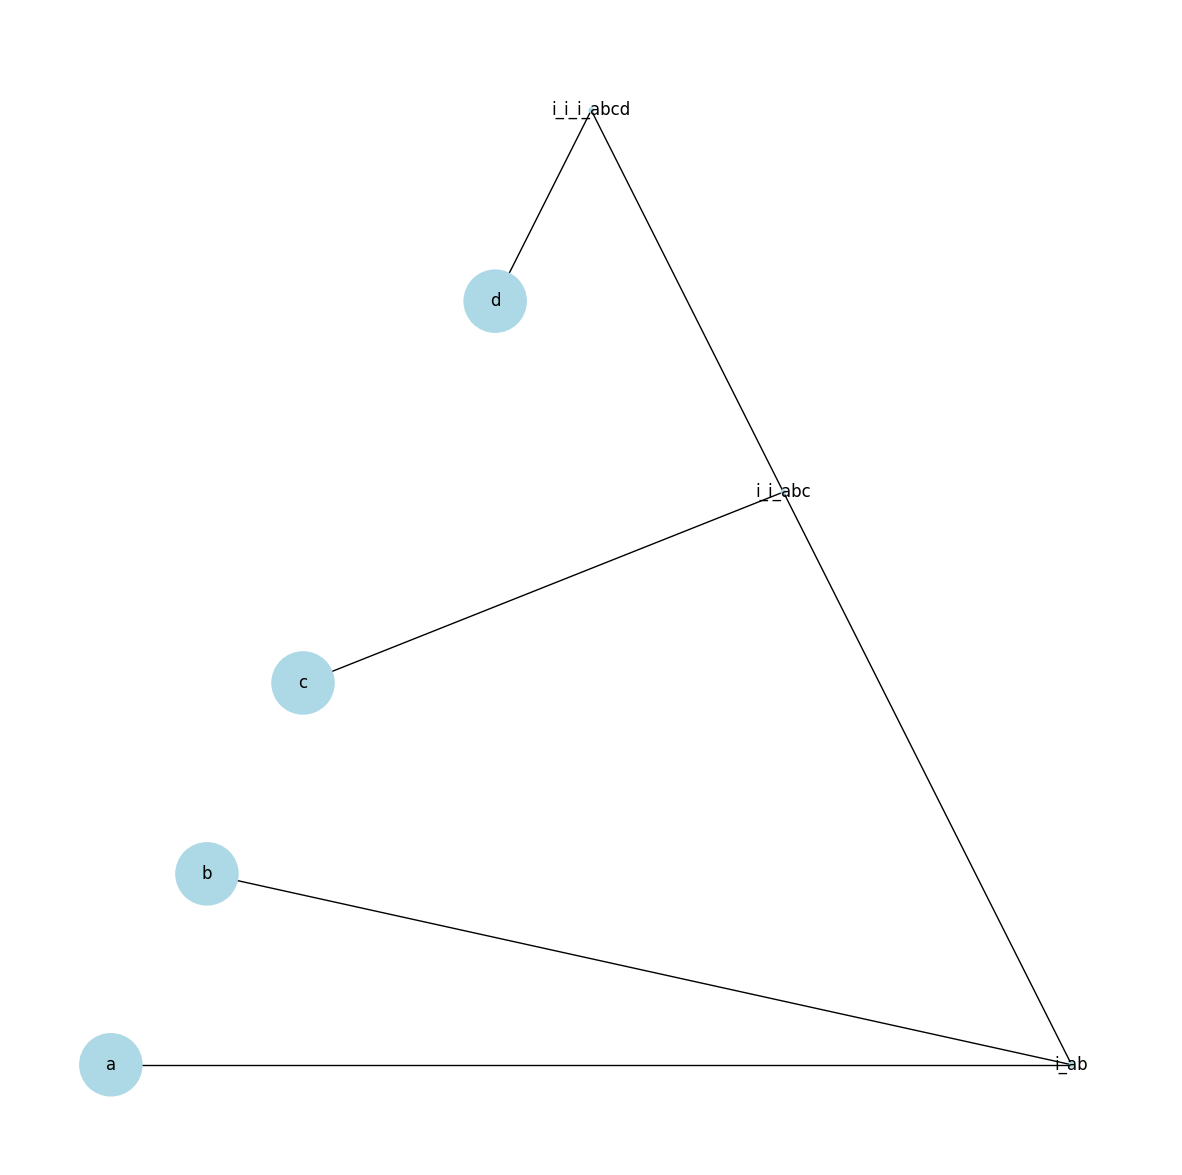

In [112]:
draw_graph_nice(G)

In [ ]:
G.edges.data()


In [132]:
# Get sequences
sequences, seq_names = utils.get_sequences_for_ancestry()
print(sequences)
print(seq_names)

adjm = [[-1 for p in sequences] for i in sequences]
for i in range(len(adjm)):
    for j in range(len(adjm[0])):
        if adjm[j][i] == -1:
            # if i == j:
            #     adjm[i][j] = 0
            # else:
            m, a = showAlignmentG(sequences[i], sequences[j], affineGap, simpleMatch)
            adjm[i][j] = a[2]
            adjm[j][i] = adjm[i][j]

import math

for i in adjm:
    for j in i:
        print(math.floor(j), end=" ")
    print()

['TGCACTCTCAGATCCTCATCTCGTTTCCATAGTTC', 'GGCGCTTCGTTCGCGTAAAGTCCCCCACCTACCGG', 'ACAATATCTCGGAACCACCACAGTGCTCTAGATAC', 'TTGCGTGGCAGAACCTAACCCGACAGTAGGCACTA', 'TCAGCGTCCGCTAGGCTAAGGCGTGAAGAGTAGCC', 'TCCGACCGACTAGCTTCGTACACTGCCAACCGCAT', 'TGACGCATGCTAATGCCCCAAAGTCTCGACAAGTC', 'TTGACGTAGATCCCCGTTGCATCGACAAGCATCAA', 'AGTTCAGGGATTGTAATTCGTCTGTAGAGTTGGGC', 'ACAATGAATGGTTGAATTGCCATACACGCGCTTAA', 'TGTGGTTCCTACCTGTCGCGTCTTTAAGGAAAGTC', 'TGTGTTGTAGCCAAAGCCGAATAATCTAATTAACG', 'TACAACCAAGCAAGCTGCAGGTGTAACGCGGTTGA', 'AGCAACTAGGTAATAAATTGCATGCAGGGCGTTCC', 'CACGCATGTTATTATGGCCCTCTATTGTATGCCCT']
['Ho-Oh', 'Toucannon', 'Stantler', 'Drapion', 'Vaporeon', 'Grumpig', 'Beheeyem', 'Snorlax', 'Doduo', 'Shaymin', 'Grovyle', 'Sawsbuck', 'Dunsparce', 'Slurpuff', 'Raichu']
TGCACTCTCAGATCCTCATCTCGTTTCCATAGTTC
TGCACTCTCAGATCCTCATCTCGTTTCCATAGTTC
35
TGCACTCTCAGATC-C-TCA--TCTCGTTTCCA--TA---GTTC
gGCgCT-TC-GtTCGCGTaAAGTCcC----CCACCTACCGG---
5.2
TGCAC----TCTCAGATCCTCATCTC-GT-TTCCATAG-TTC
---ACAATATCTCgGAaC--CAcCaCAGTGcT

AGTTCAGGGATTGTAATT-----CGTC---TGTAGAGTTGGGC---
----CAcGcA-TGTtATTATGGCCcTCTATTGTA----T--GCCCT
6.0
ACAATGAATGGTTGAATTGCCATACACGCGCTTAA
ACAATGAATGGTTGAATTGCCATACACGCGCTTAA
35
ACAATGAATGGTTGAATTGCCATAC---ACGCG-CTT------AA---
----TG--TGGTT------CC-TACCTGtCGCGTCTTTAAGGAAAGTC
8.4
ACAATGAATGGTTG------AATTGCC--ATA--C--ACGCGCTTAA--
----TG--T-GTTGTAGCCAAA--GCCGAATAATCTAA-----TTAACG
7.4
-ACAATGAATGGTTG-AATTGC--CA----TACACGCGCTTAA
TACAAccAA-----GCAA--GCTGCAGGTGTA-ACGCGgTTgA
10.2
A-CAA-TGAATGGT--TGAATTGCCATACA-CGCGCTTAA
AGCAACT-A--GGTAATaAATTG-CATgCAGgGCG-TTcc
11.600000000000001
ACA---ATG--A--ATGG---T-TGAATTGCCATACACGCGCTTAA
-CACGCATGTTATTATGGCCCTCT--ATTG---T--AtGCcCT---
7.6
TGTGGTTCCTACCTGTCGCGTCTTTAAGGAAAGTC
TGTGGTTCCTACCTGTCGCGTCTTTAAGGAAAGTC
35
TGTGGTTCCTA-CC--TGTCGCG-----TCT--TTAAGGAAAGTC
TGT-GTT-gTAGCCAAaG-C-CGAATAATCTAATTAAcG------
7.8
TGTGGTTCCTACC--------------TGT--CGCGTCTTTAAGGAAAGTC
------TaCaACCAAGCAAGCTGCAGGTGTAACGCGg--TT---GA-----
1.8000000000000003
TG----T-GGT------TCCTACCTGTC---GCG-

tREE VALS before [[[35, 5.2, 7.6, 5.6, 4.2, 6.199999999999999, 11.799999999999999, 10.2, 8.799999999999999, 3.4, 7.199999999999999, 3.7999999999999994, 3.4000000000000004, 6.0, 5.6], [5.2, 35, 4.799999999999999, 5.400000000000001, 4.999999999999999, 6.399999999999999, 6.6, 4.800000000000001, 5.6, 2.599999999999999, 6.6, 5.0, 2.0, 1.2000000000000002, 2.8], [7.6, 4.799999999999999, 35, 9.8, 4.6, 6.199999999999999, 9.0, 5.0, 4.999999999999998, 11.2, 5.2, 4.800000000000001, 5.6, 7.199999999999999, 5.400000000000001], [5.6, 5.400000000000001, 9.8, 35, 8.2, 5.3999999999999995, 7.799999999999999, 12.799999999999999, 4.4, 5.0, 6.800000000000001, 8.6, 5.6, 2.0, 3.8], [4.2, 4.999999999999999, 4.6, 8.2, 35, 8.8, 9.399999999999999, 4.2, 7.799999999999999, 2.7999999999999994, 9.0, 5.2, 7.2, 7.400000000000001, 5.8], [6.199999999999999, 6.399999999999999, 6.199999999999999, 5.3999999999999995, 8.8, 35, 8.399999999999999, 9.0, 2.2000000000000006, 6.6, 4.2, 5.999999999999999, 6.8, 4.800000000000001, 6.

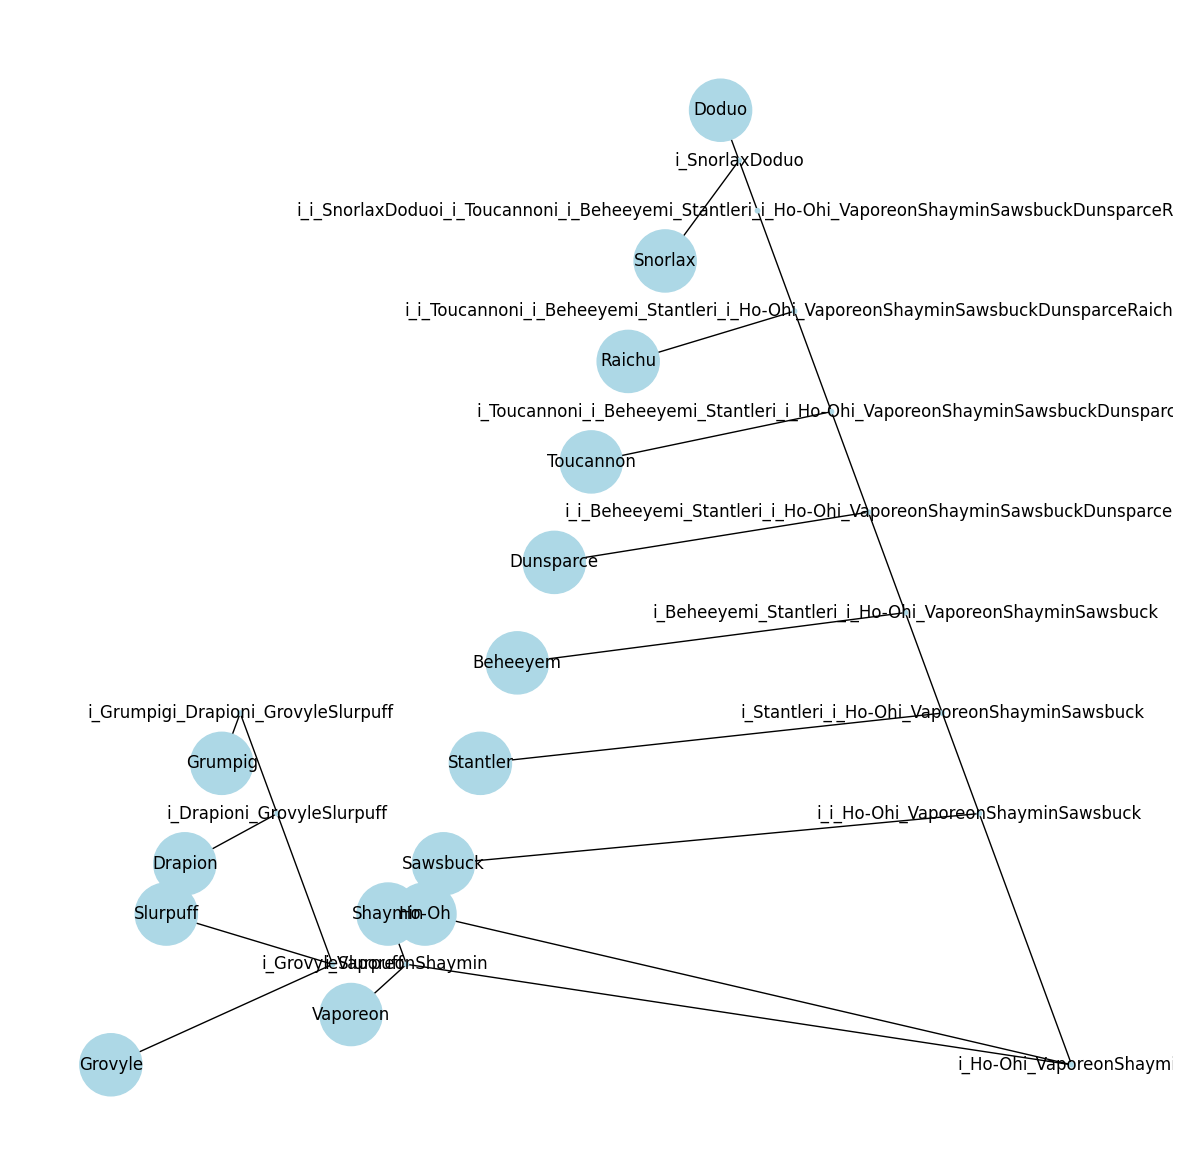

In [133]:
# Your code here
G = construct_alignment(adjm, seq_names)
draw_graph_nice(G)


<div class="alert alert-success">
    
**Problem 4 (b).** Given $n$ sequences each of roughly the same length $m$, what would the time complexity be for constructing such a phylogenetic tree? Can you think of any algorithms or heuristics that might make the process faster? 
    
</div>

In [ ]:
#G.edges.data()
print(list(nx.connected_components(G)))
#print(G.adj["Slurpuff"])
#print(G.adj['i_GrovyleSlurpuff'])



Upon analyzing the complexity of our algorithm, we discovered that we could do the generate_Q and find_min_Q step in one go, so instead of 2 passes through the n x n Q matrix, we generate and store the lowest value at the same time. This doesn't change the asymptotic complexity, but it does lower our pass from $O(2n^{2})$ to $O(n^{2})$, a subtle way to make the algorithm faster. The rest of our neighboor-join algorithm doesn't do more than $O(n^{2})$ work, so we drop these terms. Finally, we need to do the above-mentioned steps n times, each time with our Q matrix shrinking to size (n-1). This leads to a runtime of $O(n^{3})$. This could be potentially dwarfed by the first step in building a phylogenetic tree. We first need to construct the distance matrix using Needleman-Wunsch. This runtime is $O(m^{2})$ to align 2 sequences of length m. We call this algorithm $O(n^{2})$ to fill the n x n distance matrix we will need for our neighbor-joining algorithm. If n = m, we now have a complexity of $O(n^{4})$, which has a higher degree then Neighboor-Join and becomes the complexity of our entire algorithm. For a tighter bound for our distance matrix, we can say $\theta(n^{2}m^{2})$, but this means then that we must stick with the neighboor-joining complexity of $O(n^{3})$

<div class="alert alert-success">

**Problem 4 (c).** Assume a direct correlation between the distance between any two nodes and the number of years (in millions) between their evolution. Assuming `Grumpig` was the first Pokémon to evolve, when did life first come to be in the fictional scenario?
</div>

<div class="alert alert-warning">

For this part, feel free to use any of `networkx`'s in-built functions (or any graph-specific library you may have chosen for Problem 4).
</div>

In [ ]:
# Your code here

In [ ]:
how_long_ago = "???"  # Replace with your answer
print(f"Life evolved {how_long_ago} million years ago in the Pokémon world")

One way to test the robustness of such a tree reconstruction algorithm is to consider collection of nodes independently and see if the recontructed sub-trees match the bigger tree.

<div class="alert alert-success">
    
**Problem 4 (d).** Find an  edge between intermediate nodes with the largest weight in the phylogenetic tree and remove that edge- this will produce two disjoint cluster of nodes. Re-run your tree reconstruction algorithm on these two sets of Pokémons. Do your reconstructed tree match the larger phylogenetic tree?
</div>

<div class="alert alert-warning">

For this part, feel free to use any of `networkx`'s in-built functions (or any graph-specific library you may have chosen for Problem 4).
</div>

In [ ]:
#find the maximum weighted edge
nodes = list(G.edges.data()) 
max_weighted_node = ("null", "null", {'weight': -99})
max_weight = -99
for node in nodes:
    node_weight = node[2]
    if node_weight['weight'] > max_weighted_node[2]['weight']:
        max_weight = node_weight['weight']
        max_weighted_node = node
print("First try", max_weighted_node)


#def check_intermediate():
    
#remove the maximum weighted node
#G.remove_edge(max_weighted_node[0], max_weighted_node[1])

#split the two graphs
newgraphs =  list(nx.connected_components(G))


#seq1 
draw_graph_nice(G)

We can see visually that the two graphs we have created are in fact subgraphs of the original alignment we made. 

<div class="alert alert-success">

**Problem 4 (d).** Can you inspect the matrix of distances between the Pokémons and predict whether the reconstructed trees would always be unique? Why/why not?
</div>

Yes, if in our distance matrix we have strictly unique distances between each sequence pair i and j such that i != j, then we know that our reconstructed tree will be unique. We cannot make this guarantee if there are multiple identical distances in our matrix. Which pairing the algorithm chooses will depend on the it's implementation.

## Part 5: Tracing Evolution

<div class="alert alert-warning">
    This problem is a "Challenge Problem". This means it is a problem of unknown difficulty that might be quite challenging (unlike the earlier problems, we don't have a reference solution for this one, or a clear idea how hard it might be). We do hope all students will at least attempt this and that more ambitious students will work hard to solve it and learn interesting things by the attempt (whether or not it is successful), but not get frustrated if you can't get to the desired answer.  As a "Challenge Problem" it means that you shouldn't be worried if you are not able to solve this, though, and you can get full expected credit on this assignment without answering it.
</div>


Now that we can construct Phylogenetic trees using sequence alignment, we can attempt to construct these trees for different organisms and trace their evolution through time. You're given reads processed from a FASTA file for Hemoglobin Beta Proteins, which can be used to then trace evolution based on how similar their sequences are across organisms from different kingdoms. Each record has the following relevant information in Tuple format:

`((uniprot identifier, full name, shortened name, group), (sequence))`

As you may notice, running our nearest-neighbor reconstruction algorithm on this data will give a Phylogenetic tree that does not fully correspond to what we know about the evolution of these species.

<div class="alert alert-success">
    
**Problem 8 (Challenge).** Construct a Phylogenetic Tree using the given sequences. Implement and use any tree-reconstruction method of your choice, and see if it works better than the nearest-neighbor method with a linear-gap penalty.
    
For visualization, use the short name to display in the evolution tree.
    
</div>
    
This is an open-ended question, and is inspired by https://www.mimuw.edu.pl/~lukaskoz/teaching/sad2/lab6/readme.html. You are free to use any approach to deal with the issue. Make sure you provide your code, along with any assumptions you may have.

In [111]:
sequences = utils.get_sequences_for_tree()
print(sequences[0])
print(sequences[1])
print(sequences[0][1] == sequences[1][1])

(('P01941.1', 'Tupaia glis', 'Tgli', 'Mammalia'), 'VLSPGDKSNIKAAWGKIGGQAPQYGAEALERMFLSFPTTKTYFPHFDMSHGSAQIQAHGKKVADALSTAVGHLDDLPTALSALSDLHAHKLRVDPANFKLLSHCILVTLACHHPGDFTPEIHASLDKFLANVSTVLTSKYR')
(('P11755.1', 'Tadarida brasiliensis', 'Tbra', 'Mammalia'), 'VLSPEDKNNVKAAWSKVGGQAGDYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVGEALTTAVNHMDDLPGALSTLSDLHAYKLRVDPVNFKLLSHCLLVTLACHNPGEFTPAVHASLDKFLASVSTVLTSKYR')
False


In [112]:
# Your code here

# all sequences are length 141
print(len(sequences[0][1]) == len(sequences[5][1]) == 141)

def oneToOneScore(s1, s2):
    # assumes they are the same length
    if len(s1) != len(s2):
        return False
    numMatches = 0
    for s in range(len(s1)):
#         print(s)
        if s1[s] == s2[s]:
#             print(s1[s], s2[s])
            numMatches += 1
    return numMatches

print(oneToOneScore(sequences[0][1], sequences[1][1]))

True
115


In [113]:
matrix = [[0 for i in sequences] for j in sequences]

for i in range(len(matrix)):
    for j in range(len(matrix[i])):
        r = oneToOneScore(sequences[i][1], sequences[j][1])
        matrix[i][j] = 141-r
#         print(i, j, r[1][2])

In [114]:
# number of mismatches
for i in matrix:
    for j in i:
        print(j, end=" ")
    print("")
    
# Kruskal's on the nodes
import heapq
pq = []

G = nx.Graph()
# G.add_edge("pikachu", "weedle")

for i in range(len(matrix)):
    for j in range(0, i):
        heapq.heappush(pq, (matrix[i][j], i, j))
#         print(matrix[i][j], end=" ")
#     print()
    
pp = len(pq)
edges = []

sets = [i for i in range(len(matrix))]

while pq:
    node = heapq.heappop(pq)
    score = node[0]
    i = node[1]
    j = node[2]

    if sets[i] != sets[j]:
        G.add_edge(sequences[i][0][2], sequences[j][0][2])
        edges.append([sequences[i][0][2], sequences[j][0][2], score])
#         print(sequences[i][0][1], sequences[j][0][1])
        
        x1 = sets[j]
        for x in range(len(sets)):
            if sets[x] == x1:
                sets[x] = sets[i]
        sets[j] = sets[i]


print(sets)

0 26 25 24 30 30 61 26 31 29 
26 0 16 24 22 23 53 14 25 16 
25 16 0 19 20 21 53 12 22 6 
24 24 19 0 24 27 57 27 24 23 
30 22 20 24 0 5 55 19 9 20 
30 23 21 27 5 0 54 20 10 21 
61 53 53 57 55 54 0 50 57 55 
26 14 12 27 19 20 50 0 25 14 
31 25 22 24 9 10 57 25 0 20 
29 16 6 23 20 21 55 14 20 0 
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [115]:
def score_tree(edges):
    # count number of character-state changes
    changes = 0
    for edge in edges:
        changes += edge[2]
    return changes

158


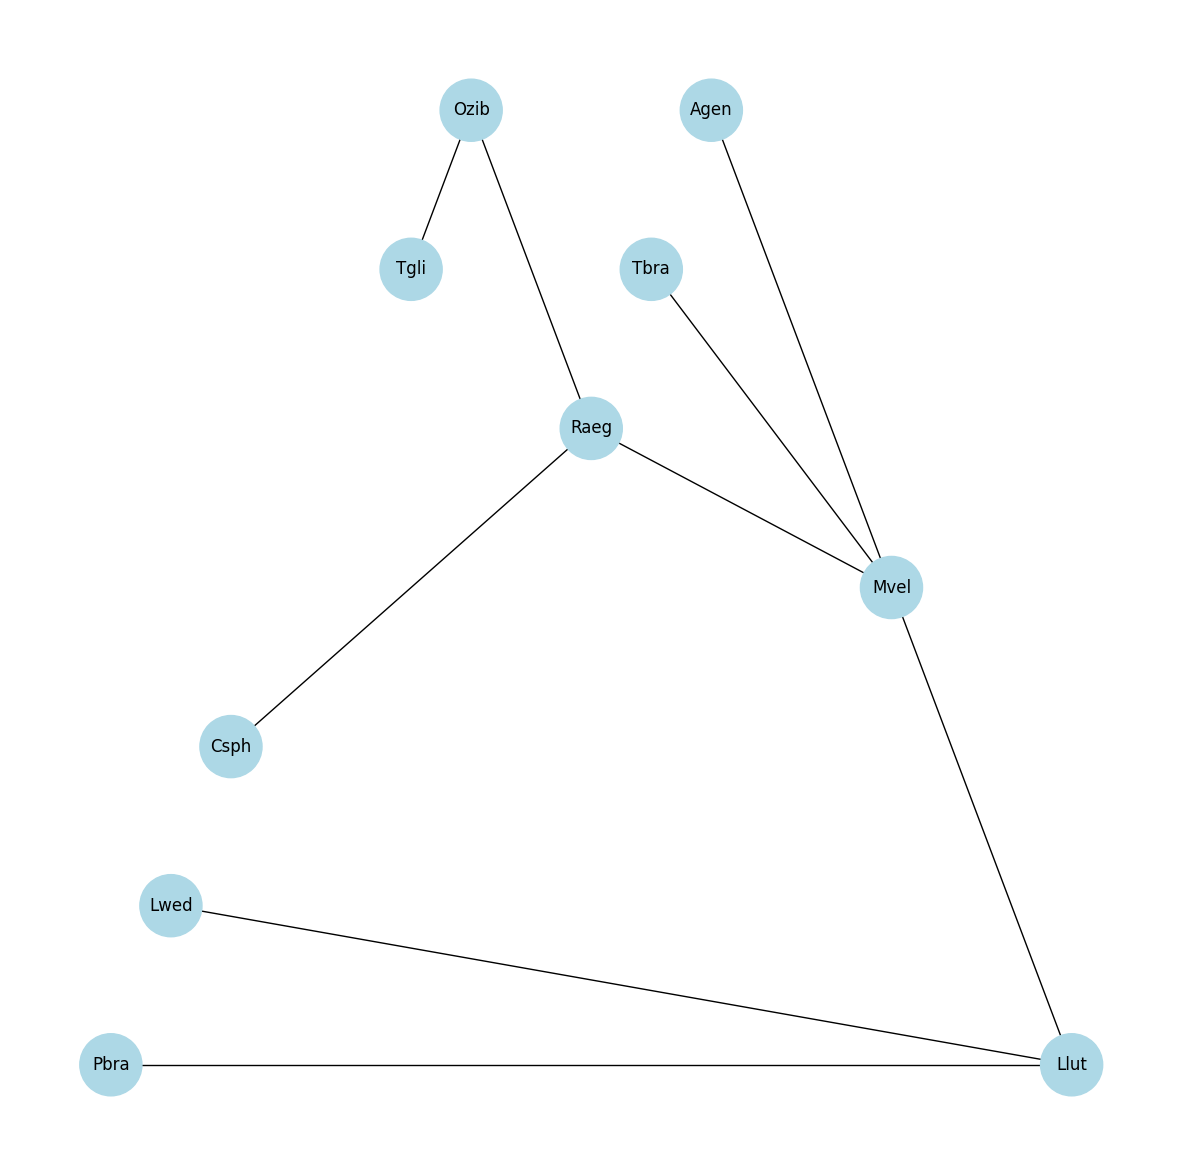

In [116]:
draw_graph_nice(G)
score = score_tree(edges)
print(score)

We attempted to use Kruskal's simply to link the genomes together in a minimum spanning tree. Unlike minimum neighbors it does not create intermediate notes but only links the given nodes together. From the spanning tree produced, it seems that Mvel may be a common ancestor for the other genes since it's at the center.

This implementation was based on the idea of maximum parsimony, or the simplest tree, or the minimum homoplasy. It links together similar genomes together, but leaf siblings may not be similar to each other, only the parent.

<div class="alert alert-success">
    
Is this (using Hemoglobin proteins) the best way to trace and visualize evolution? Why do you think it is useful, and what could the possible downsides of this be?
    
</div>

This assumes that the ancestors are given alongside the modern genomes, which is typically not the case. It's useful for when we know a group of organisms and want to find out the relationship. Also, the "distance" between nodes was just a one-to-one gap so a very rudimentary global alignment, which was useful in this case since each sequence was 141 characters long and very similar to each other.
Lastly, it was rather lucky that the tree generated looked like a rooted tree, which might be based on the data provided. Maybe due to the nature of the hemoglobin sequences, Kruskal's may not be a bad solution. However, for other genomes, this algorithm would perform very badly, and most of the times not even give a rooted tree.

   <div class="alert alert-block alert-danger">
    <center>
      
**End of Project 2!**
        
Remember to follow the submission directions above to submit your assignment.
    
 </center>
 </div>